In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/jovyan/20230406_ArticleClassifier/ArticleClassifier")
from src.general.utils import cc_path
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from src.visualization.visualize import visualize_individual_label_performance
from scipy.stats import linregress


In [36]:
labels = ['human', 'mouse', 'rat', 'nonhuman', 'controlled study',
       'animal experiment', 'animal tissue', 'animal model', 'animal cell',
       'major clinical study', 'clinical article', 'case report',
       'multicenter study', 'systematic review', 'meta analysis',
       'observational study', 'pilot study', 'longitudinal study',
       'retrospective study', 'case control study', 'cohort analysis',
       'cross-sectional study', 'diagnostic test accuracy study',
       'double blind procedure', 'crossover procedure',
       'single blind procedure', 'adult', 'aged', 'middle aged', 'child',
       'adolescent', 'young adult', 'very elderly', 'infant', 'school child',
       'newborn', 'preschool child', 'embryo', 'fetus', 'male', 'female',
       'human cell', 'human tissue', 'normal human', 'human experiment',
       'phase 2 clinical trial', 'randomized controlled trial',
       'clinical trial', 'controlled clinical trial', 'phase 3 clinical trial',
       'phase 1 clinical trial', 'phase 4 clinical trial']

In [37]:
def visualize_individual_label_performance(model_log):
    model_log = model_log.loc[(model_log['gnn_type'] == 'GAT') & \
                         (model_log['num_conv_layers'] == 1) & \
                         (model_log['embedding_size'] == 256) & \
                         (model_log['hidden_channels'] == 16) & \
                         (model_log['graph_num_epochs'] > 500) & \
                         (model_log['embedding_type'] == 'label_specific') & \
                         (model_log['data_type_to_use'] == "['keyword']") & \
                         (model_log['subsample_size'] == 56337) & \
                         (model_log['used_gnn'].isna()) & \
                         (model_log['pretrain_lr'].isna()) & \
                         (model_log['edge_weight_threshold'].isin([0.001, 0.002, 0.0025, 0.0033, 0.005, 0.01, 0.0125, 0.0167, 0.025, 0.05, 0.0667, 0.1, 0.2, 0.5])) & \
                         (model_log['heads'] == 4), :]
    

    f1_labels = ['f1_' + label for label in labels]
    pivotted_log = model_log[f1_labels+['edge_weight_threshold']].pivot(columns='edge_weight_threshold')
    
    df = pivotted_log.copy()
    df.columns = ['-'.join([str(a) for a in col]) for col in df.columns]

    # Convert the DataFrame to long format for seaborn
    df = df.reset_index().melt(id_vars='index', var_name='label_threshold', value_name='score')

    # Split the combined column into separate label and threshold columns
    df['label'] = df['label_threshold'].apply(lambda x: x.split('-')[0] if '-' in x else x)
    df['threshold'] = df['label_threshold'].apply(lambda x: x.split('-')[1] if '-' in x else 'NaN')

    # Convert 'threshold' column to numeric, errors='coerce' will turn 'NaN' strings into actual NaNs
    df['threshold'] = pd.to_numeric(df['threshold'], errors='coerce')
    
    # # Plot the data
    # plt.figure(figsize=(20, 10))
    # sns.catplot(data=df, x='label', y='score', hue='threshold', kind='bar', height=5, aspect=3)
    # plt.xticks(rotation=90)
    # plt.title('Score by label and threshold')
    # plt.ylabel('Score')
    # plt.xlabel('Label')
    # plt.tight_layout()
    # plt.savefig(cc_path('reports/figures/bar_threshold_label_performance.png'))
    df.dropna(subset=['score', 'threshold'], inplace=True)
    
    
    for group_name, group in df.groupby('label'):
        agg_group = group[['threshold', 'score']].groupby('threshold').agg(['mean', 'std'])
        agg_group.columns = agg_group.columns.droplevel()
        agg_group.reset_index(inplace=True)
        agg_group.plot(x='threshold', y='mean', yerr='std', capsize=3)
        plt.xscale('log')
        plt.title(f'Scores per threshold for: {group_name}')
        plt.show()

        # Fit a straight line to the data using linear regression
        x = agg_group['threshold']
        y = agg_group['mean']
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        print(f"Slope for {group_name}: {slope}")
        print(f"Standard deviation: {std_err}")
        print(f"p-value: {p_value}")


    
    print(df)
    
def visualise_f1_score(model_log):
        model_log = model_log.loc[(model_log['gnn_type'] == 'GAT') & \
                         (model_log['num_conv_layers'] == 1) & \
                         (model_log['embedding_size'] == 256) & \
                         (model_log['hidden_channels'] == 16) & \
                         (model_log['graph_num_epochs'] > 500) & \
                         (model_log['embedding_type'] == 'label_specific') & \
                         (model_log['data_type_to_use'] == "['keyword']") & \
                         (model_log['subsample_size'] == 56337) & \
                         (model_log['used_gnn'].isna()) & \
                         (model_log['pretrain_lr'].isna()) & \
                         (model_log['edge_weight_threshold'].isin([0.001, 0.002, 0.0025, 0.0033, 0.005, 0.01, 0.0125, 0.0167, 0.025, 0.05, 0.0667, 0.1, 0.2, 0.5])) & \
                         (model_log['heads'] == 4), :]
        
        macro = model_log[['edge_weight_threshold', 'graph_test_f1_score_macro']].groupby('edge_weight_threshold').agg(['mean', 'std'])
        micro = model_log[['edge_weight_threshold', 'graph_test_f1_score_micro']].groupby('edge_weight_threshold').agg(['mean', 'std'])
        
        macro.columns = macro.columns.droplevel()
        macro.reset_index(inplace=True)
        micro.columns = micro.columns.droplevel()
        micro.reset_index(inplace=True)
        
        macro.plot(x='edge_weight_threshold', y='mean', yerr='std', capsize=3)
        plt.xscale('log')
        micro.plot(x='edge_weight_threshold', y='mean', yerr='std', capsize=3)
        plt.xscale('log')

        
        


In [38]:
storage_file_path = 'model_log.csv'
model_results_df = pd.read_csv(cc_path(f'reports/model_results/{storage_file_path}'))

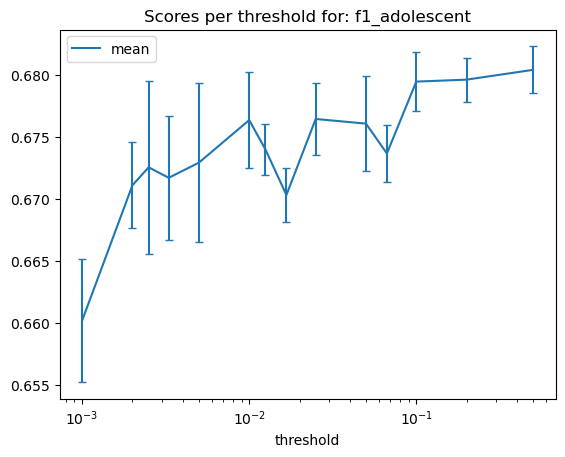

Slope for f1_adolescent: 0.02121114429855954
Standard deviation: 0.009061531861119198
p-value: 0.037332031250498374


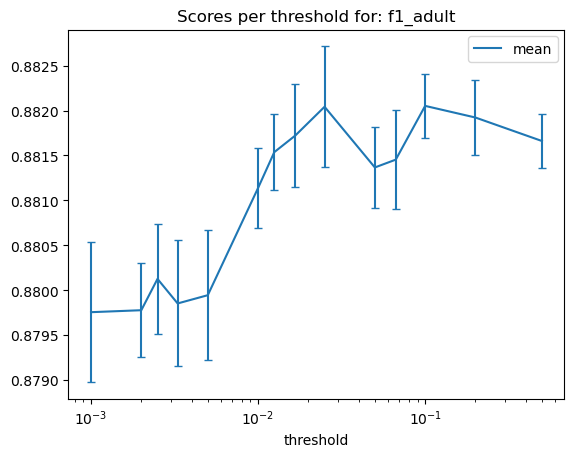

Slope for f1_adult: 0.0028425379738438905
Standard deviation: 0.0017729649901799132
p-value: 0.13485557872227844


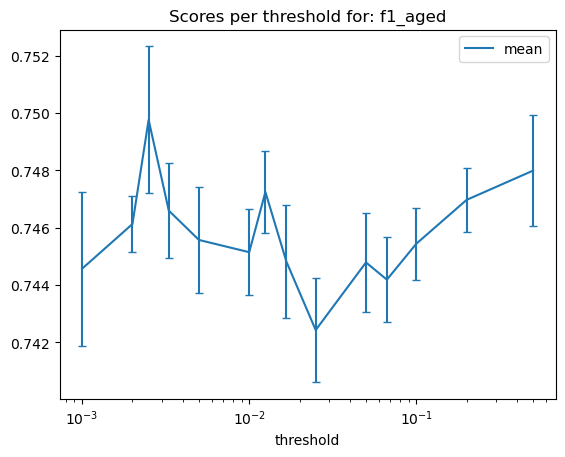

Slope for f1_aged: 0.004318606850993746
Standard deviation: 0.0036694663350635213
p-value: 0.26205144496947663


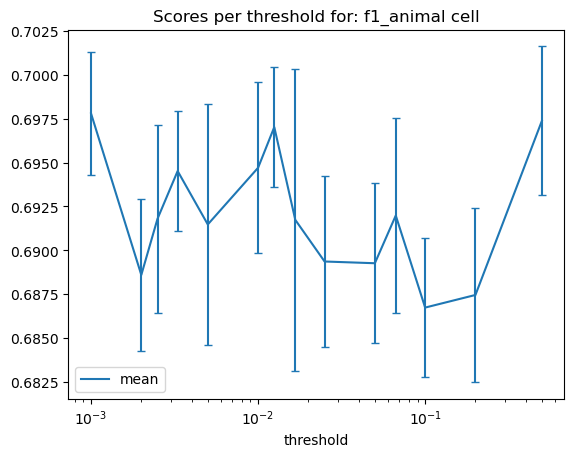

Slope for f1_animal cell: 0.004264253251811832
Standard deviation: 0.0077683464614427536
p-value: 0.5931228837186725


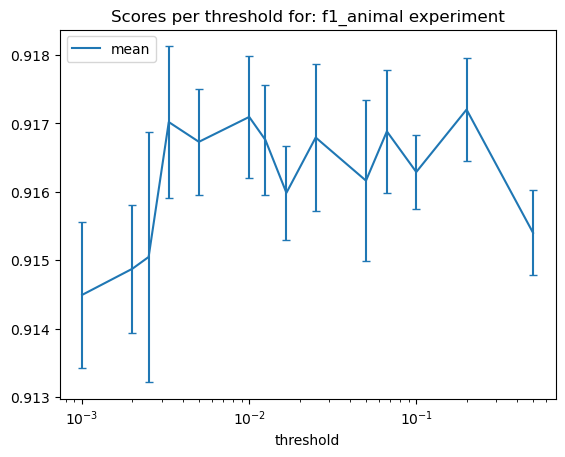

Slope for f1_animal experiment: -0.000491826272674898
Standard deviation: 0.00192112312220234
p-value: 0.8022791905456094


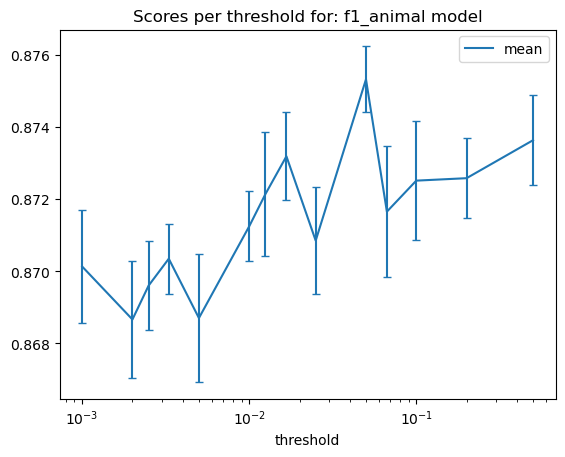

Slope for f1_animal model: 0.006750442325619586
Standard deviation: 0.00359987367826018
p-value: 0.08530231812869216


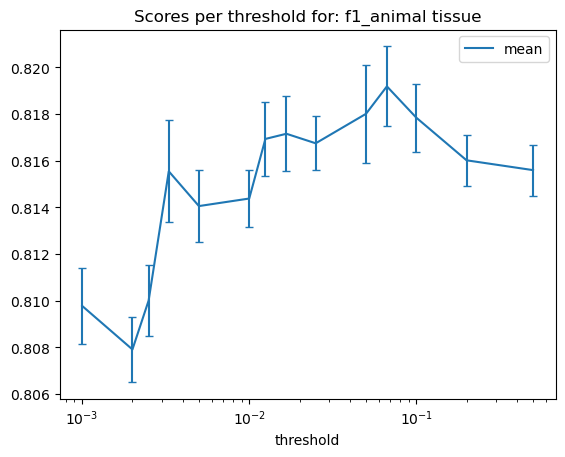

Slope for f1_animal tissue: 0.005636039315040328
Standard deviation: 0.007109537456122848
p-value: 0.44331863348106937


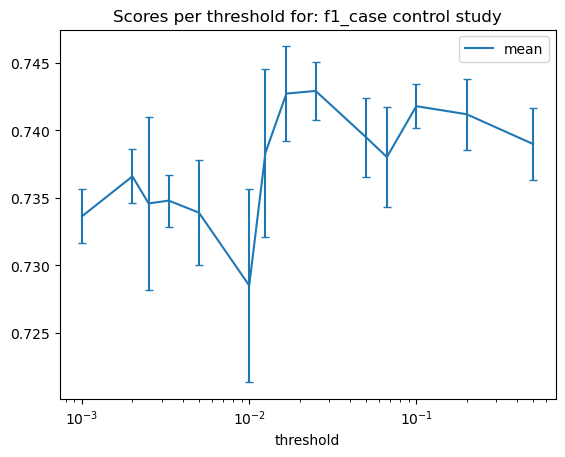

Slope for f1_case control study: 0.008898568461231483
Standard deviation: 0.008418252069616688
p-value: 0.31130194499552843


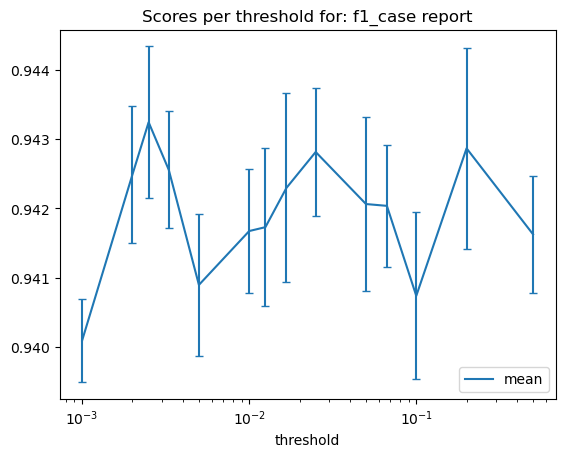

Slope for f1_case report: -0.000230599147718977
Standard deviation: 0.0019007278320606503
p-value: 0.9054442623328051


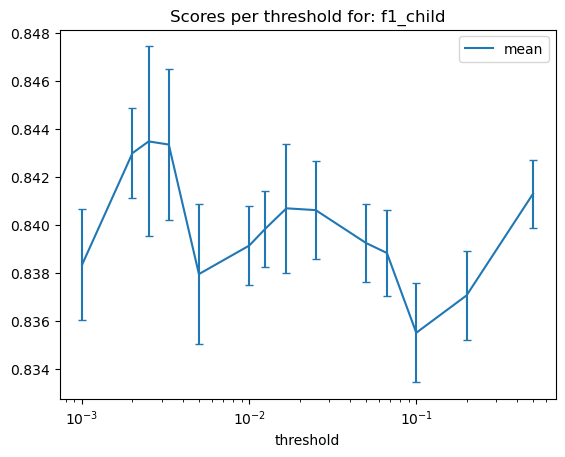

Slope for f1_child: -0.0014985996859544091
Standard deviation: 0.005048041551410217
p-value: 0.7716434688831264


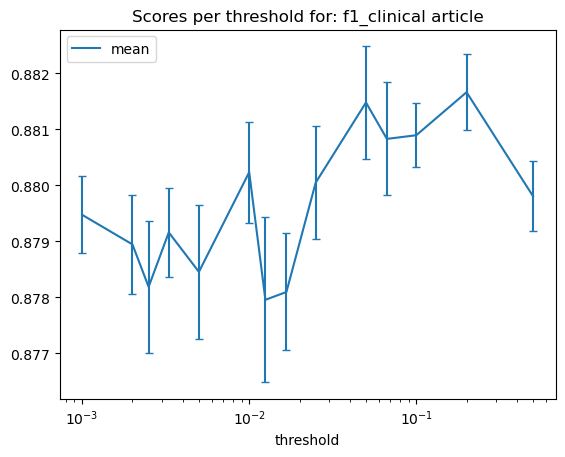

Slope for f1_clinical article: 0.003039748535408691
Standard deviation: 0.0025337783993522964
p-value: 0.2534107322386399


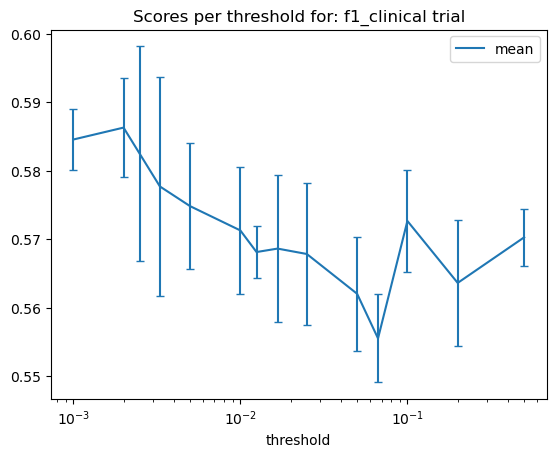

Slope for f1_clinical trial: -0.016979771819818815
Standard deviation: 0.018092247175637125
p-value: 0.3664885688652456


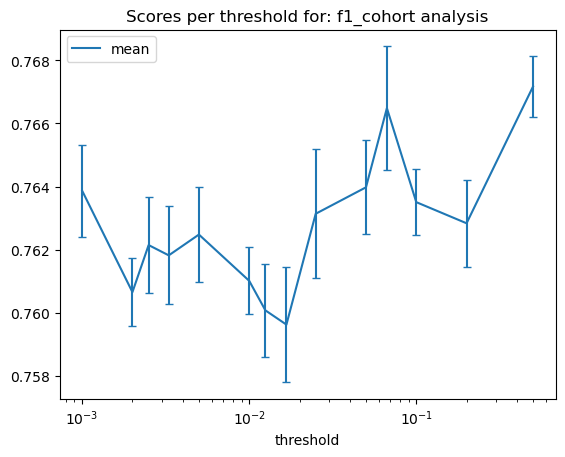

Slope for f1_cohort analysis: 0.010478585719375474
Standard deviation: 0.0035749438506750527
p-value: 0.012577806128249493


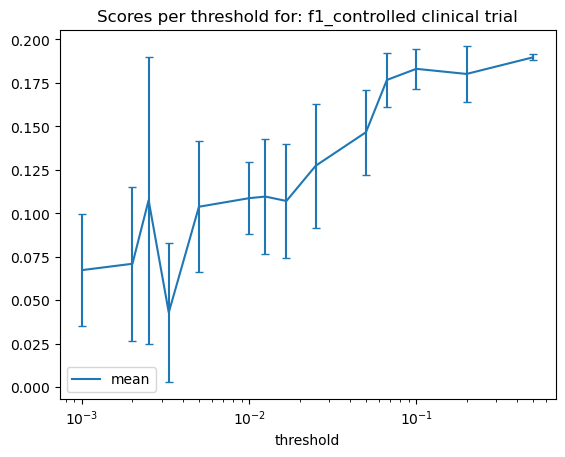

Slope for f1_controlled clinical trial: 0.22984774467406285
Standard deviation: 0.07427987884659806
p-value: 0.00928701820047669


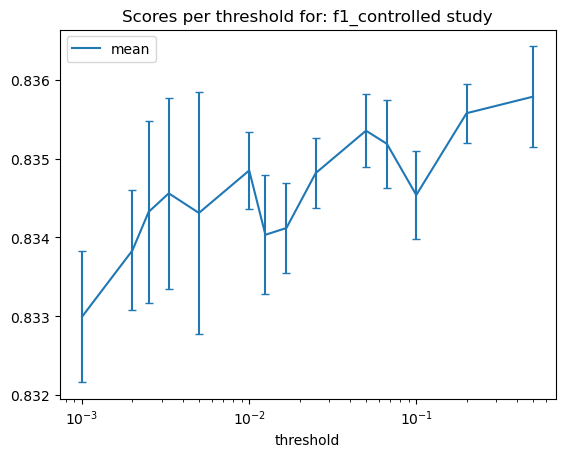

Slope for f1_controlled study: 0.0035968213710261985
Standard deviation: 0.0012112954595445756
p-value: 0.011714228121241815


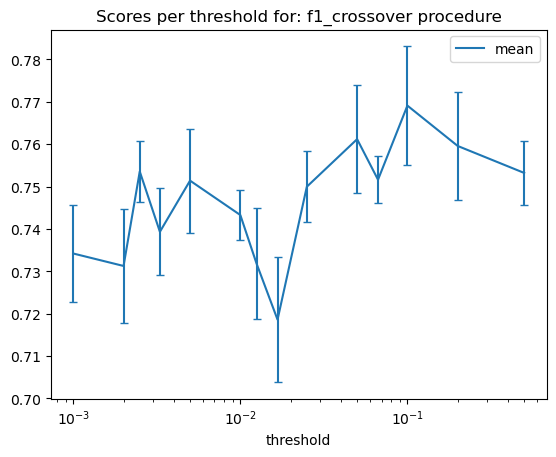

Slope for f1_crossover procedure: 0.03744879815641068
Standard deviation: 0.02752004611913493
p-value: 0.19859223411672766


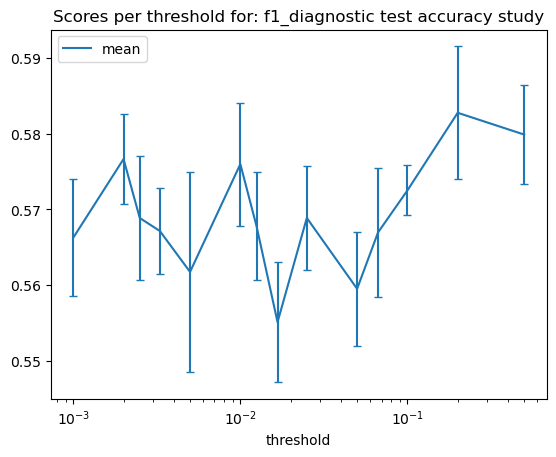

Slope for f1_diagnostic test accuracy study: 0.03133740297839632
Standard deviation: 0.013848636865236649
p-value: 0.04298918026528969


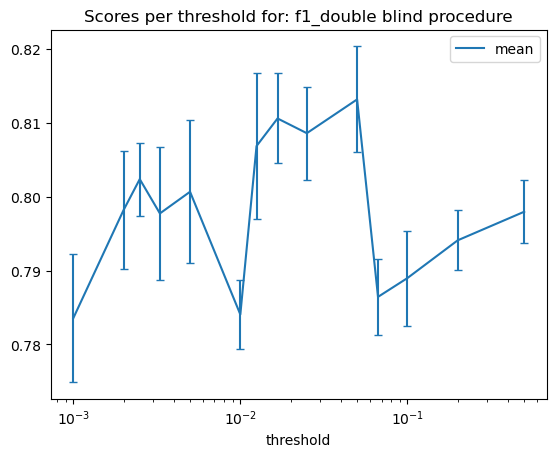

Slope for f1_double blind procedure: -0.005672807835911461
Standard deviation: 0.020783848518014222
p-value: 0.7895373276236464


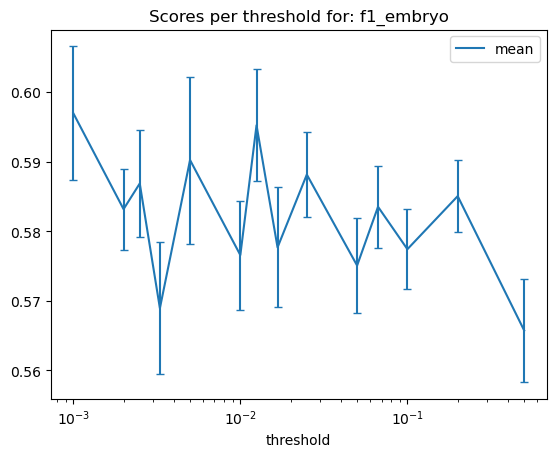

Slope for f1_embryo: -0.03449489352952741
Standard deviation: 0.0168738362198868
p-value: 0.06350927189147293


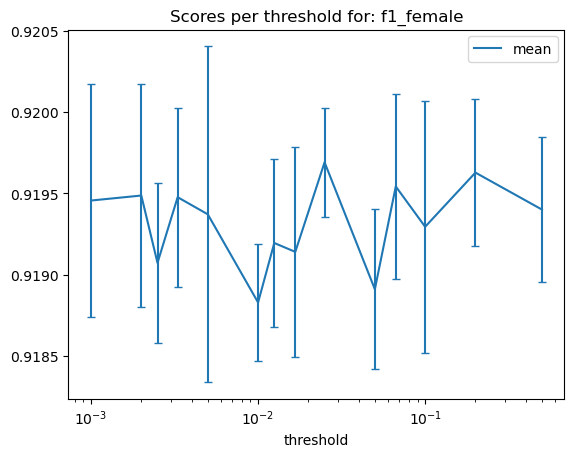

Slope for f1_female: 0.0003920711103038782
Standard deviation: 0.0005445745176483124
p-value: 0.4853377428260145


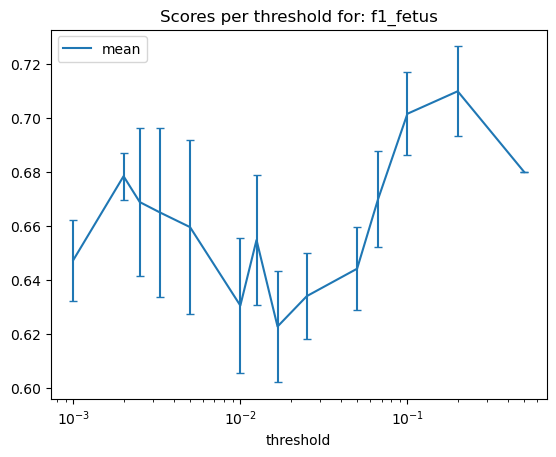

Slope for f1_fetus: 0.08635462080355726
Standard deviation: 0.04846040722902524
p-value: 0.10005523717437585


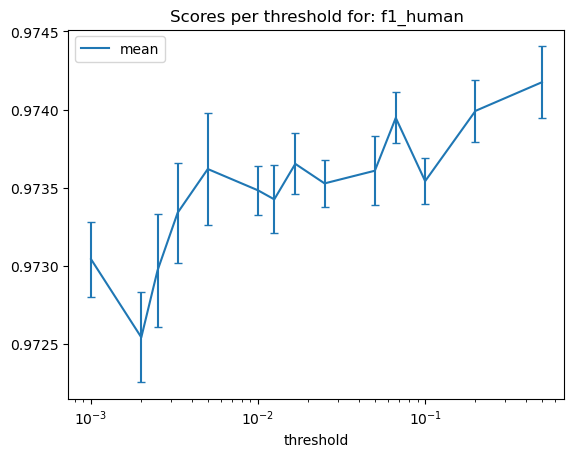

Slope for f1_human: 0.002033593307263895
Standard deviation: 0.000701341781882308
p-value: 0.013336830689081376


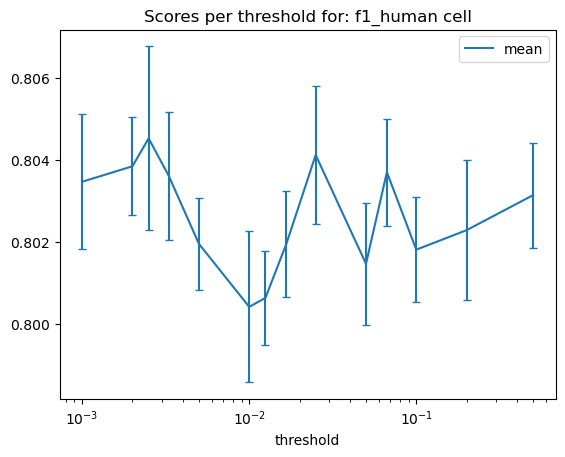

Slope for f1_human cell: 0.0004061801281015237
Standard deviation: 0.0027946427553780075
p-value: 0.8868532825396598


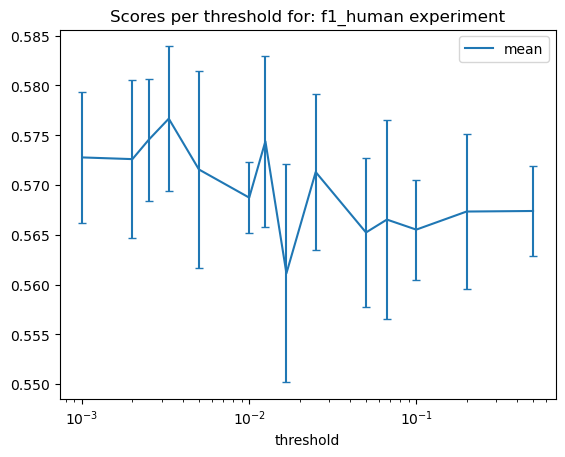

Slope for f1_human experiment: -0.01041745858228829
Standard deviation: 0.00888381822508395
p-value: 0.2636960081055516


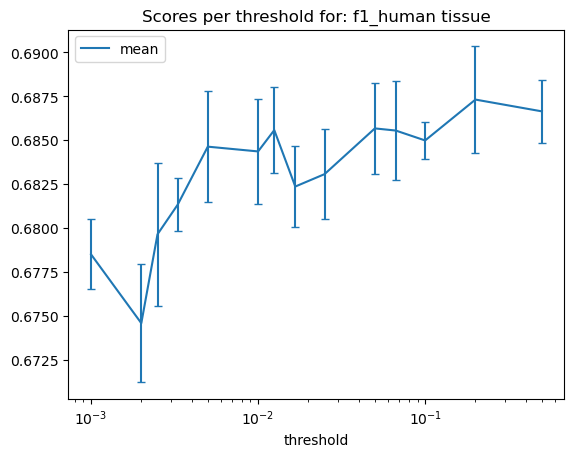

Slope for f1_human tissue: 0.012803946882743236
Standard deviation: 0.0066803847022610385
p-value: 0.07940095231947925


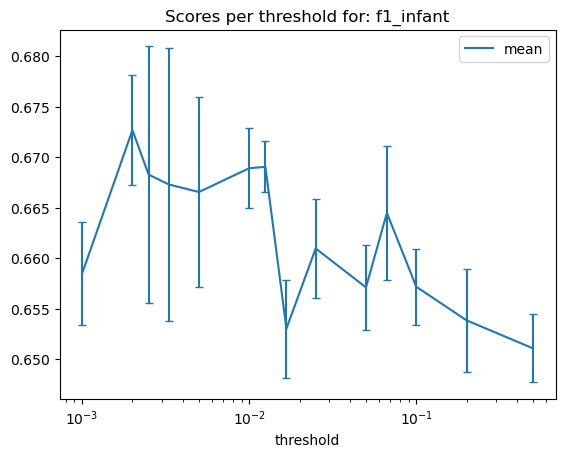

Slope for f1_infant: -0.032292469767039964
Standard deviation: 0.011633989922605021
p-value: 0.01678363377746921


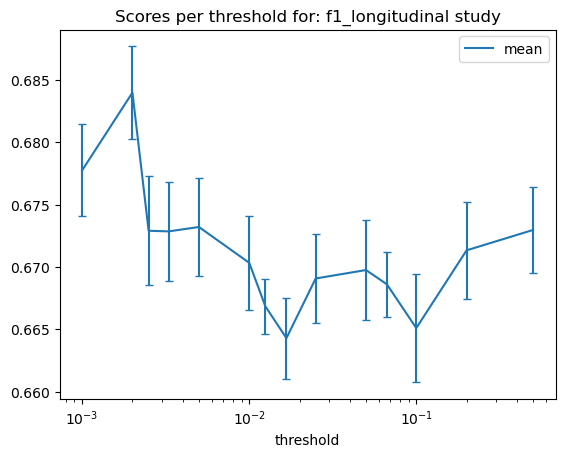

Slope for f1_longitudinal study: -0.001181170861238727
Standard deviation: 0.010869219431358467
p-value: 0.9152592996513996


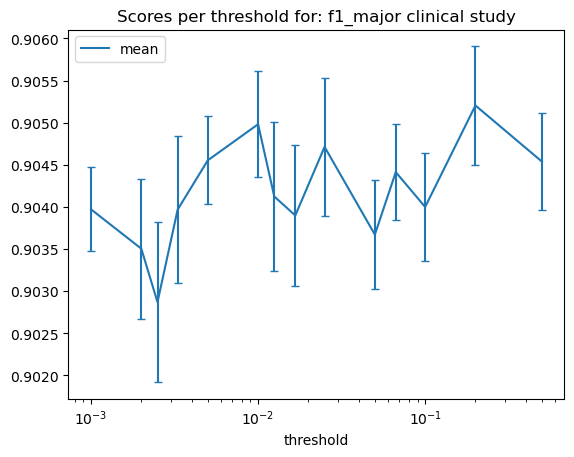

Slope for f1_major clinical study: 0.0015834405860045005
Standard deviation: 0.0012334706931808736
p-value: 0.2234717446992956


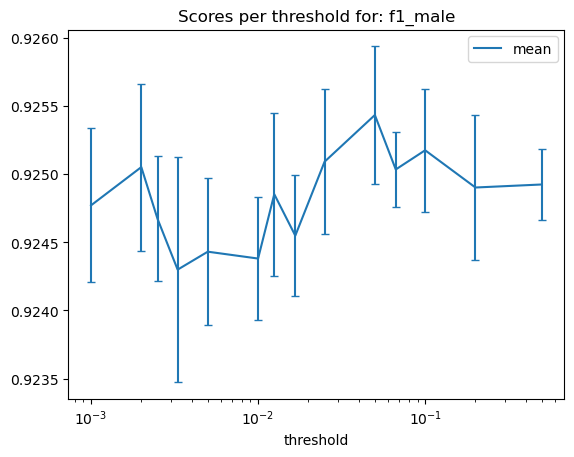

Slope for f1_male: 0.0005786869700388427
Standard deviation: 0.0006828164088298249
p-value: 0.41330082558488446


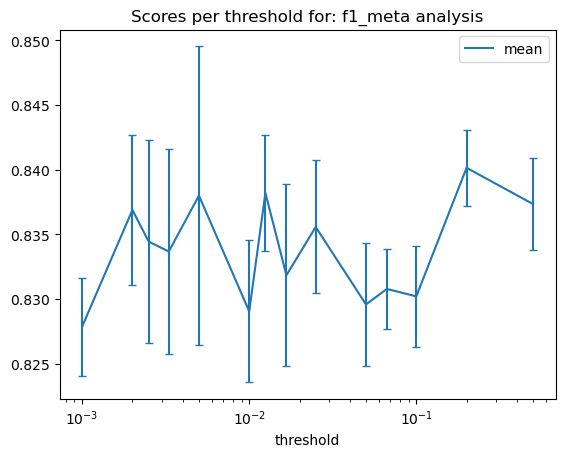

Slope for f1_meta analysis: 0.009609611532809778
Standard deviation: 0.008001264438650804
p-value: 0.25291650881151445


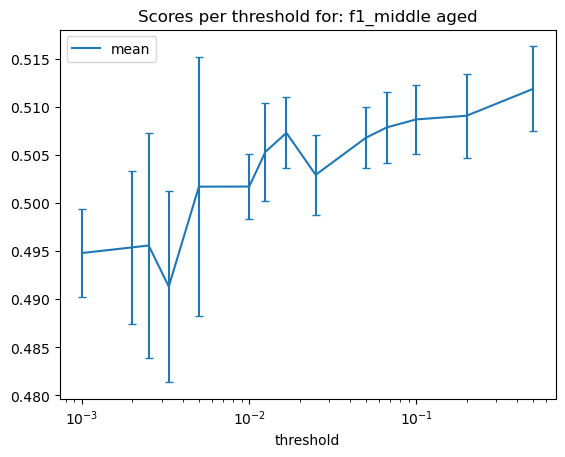

Slope for f1_middle aged: 0.028873400483464953
Standard deviation: 0.010807277099283879
p-value: 0.02034812293555603


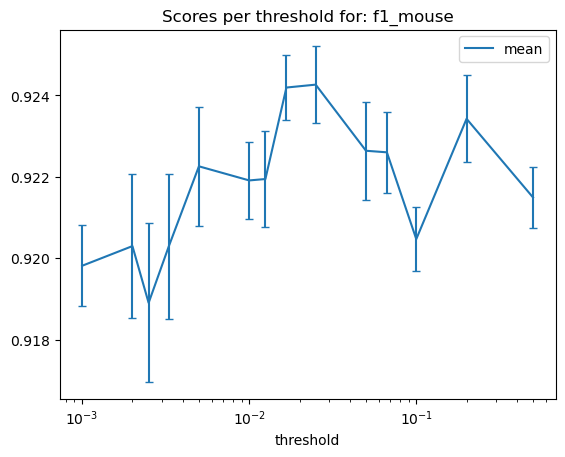

Slope for f1_mouse: 0.0011470761873355977
Standard deviation: 0.0034762306013835513
p-value: 0.747106466779943


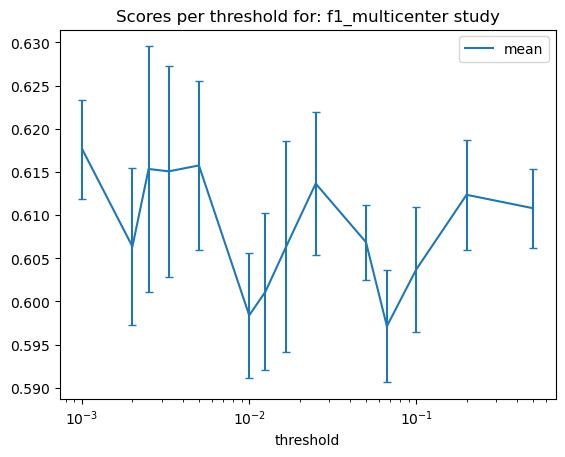

Slope for f1_multicenter study: 0.001966556204294034
Standard deviation: 0.014415007762609884
p-value: 0.8937479415727179


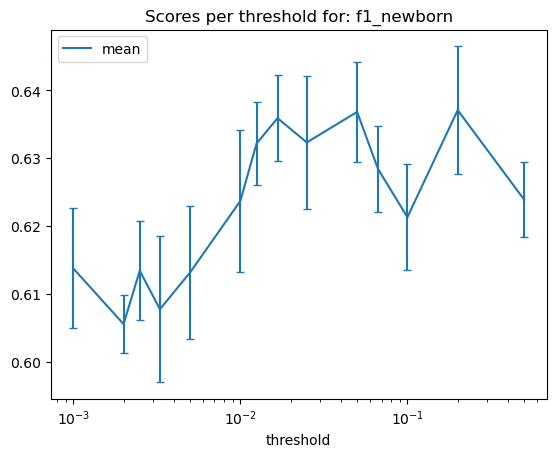

Slope for f1_newborn: 0.018173605775461812
Standard deviation: 0.022891138789865803
p-value: 0.442662258934271


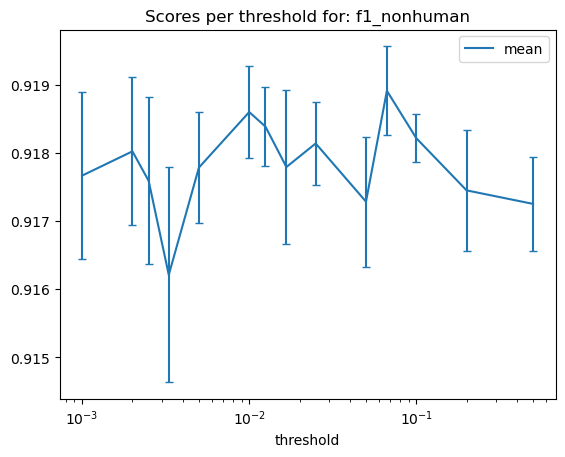

Slope for f1_nonhuman: -0.0010254606269146024
Standard deviation: 0.0013984375117903171
p-value: 0.4774629975544674


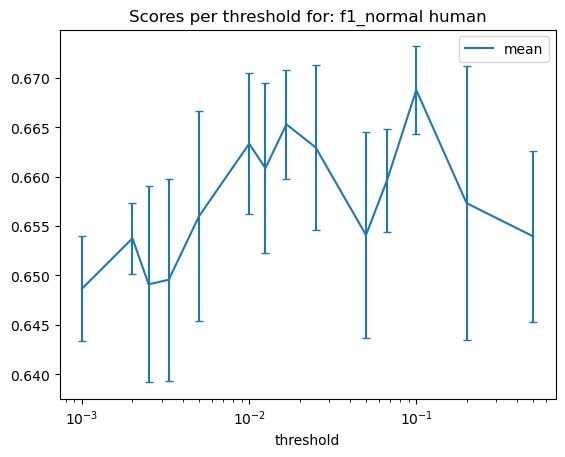

Slope for f1_normal human: -0.0012230677766358247
Standard deviation: 0.013481826584570188
p-value: 0.9292120077152132


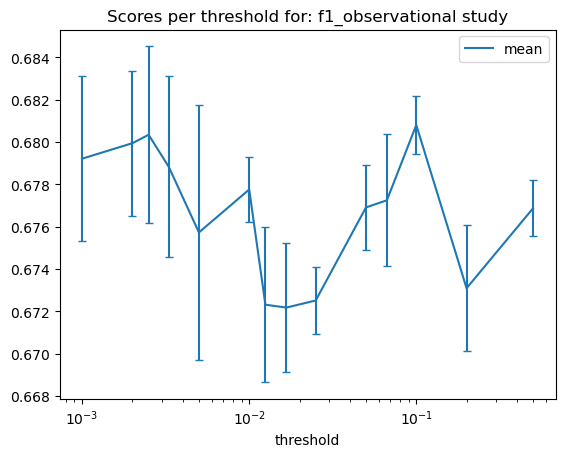

Slope for f1_observational study: -0.0015965385570251916
Standard deviation: 0.006584555895930694
p-value: 0.8125127320914121


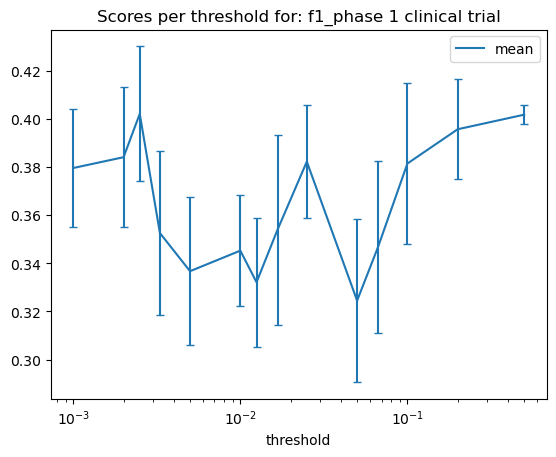

Slope for f1_phase 1 clinical trial: 0.09211728955512055
Standard deviation: 0.050605036071069455
p-value: 0.09372668952553027


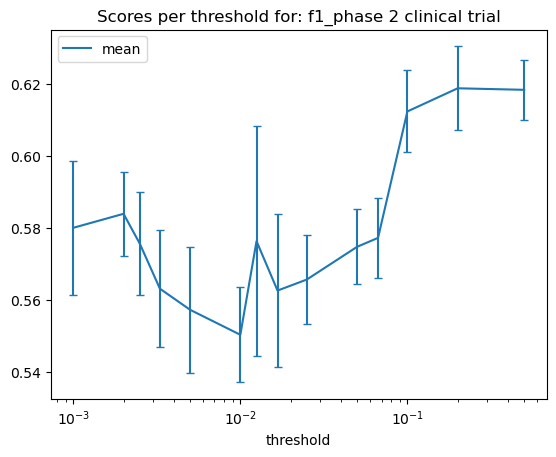

Slope for f1_phase 2 clinical trial: 0.12135796788040737
Standard deviation: 0.03133990136442845
p-value: 0.0022185547722165183


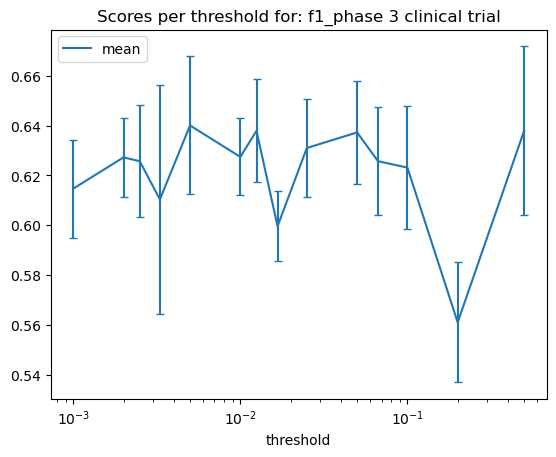

Slope for f1_phase 3 clinical trial: -0.009621333985821118
Standard deviation: 0.04441627299315656
p-value: 0.8321454567439873


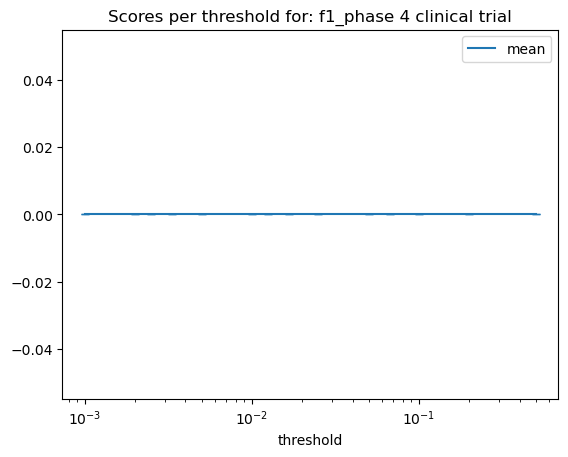

Slope for f1_phase 4 clinical trial: 0.0
Standard deviation: 0.0
p-value: 1.0


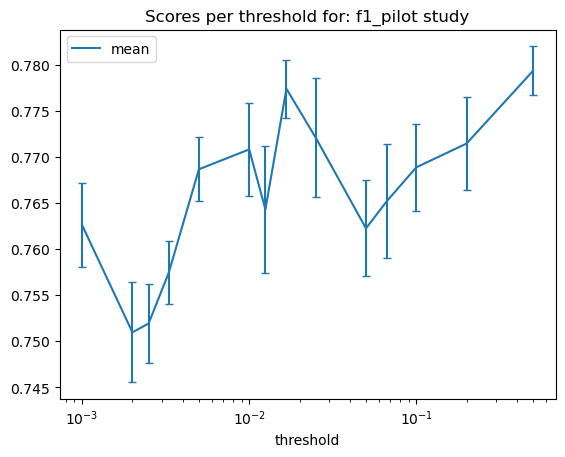

Slope for f1_pilot study: 0.0342909754008211
Standard deviation: 0.015223638469744274
p-value: 0.0438007519206538


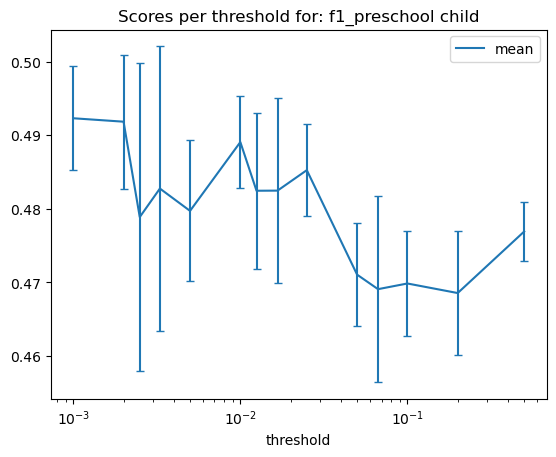

Slope for f1_preschool child: -0.024018153423008996
Standard deviation: 0.015993589203848132
p-value: 0.15901400505787966


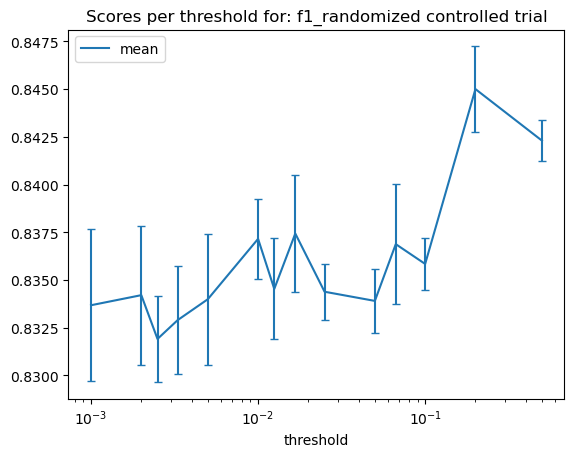

Slope for f1_randomized controlled trial: 0.020315061739971992
Standard deviation: 0.0051401155504122035
p-value: 0.0019199530657037784


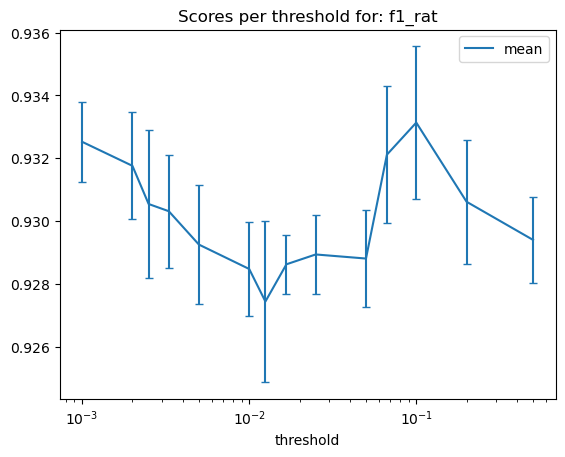

Slope for f1_rat: -4.865587865941369e-05
Standard deviation: 0.0036775519380501816
p-value: 0.9896613121022075


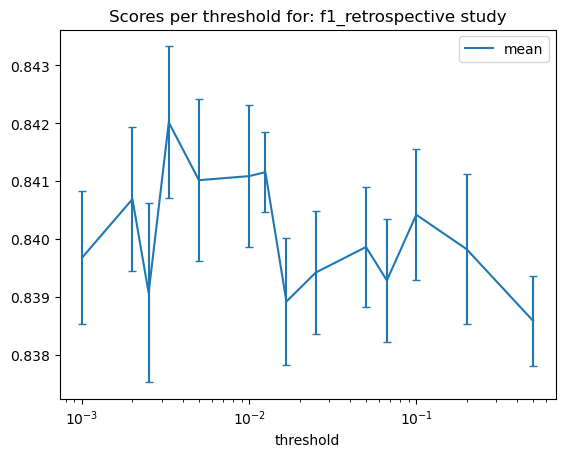

Slope for f1_retrospective study: -0.0034657941789242035
Standard deviation: 0.001904714626875441
p-value: 0.09384392372228698


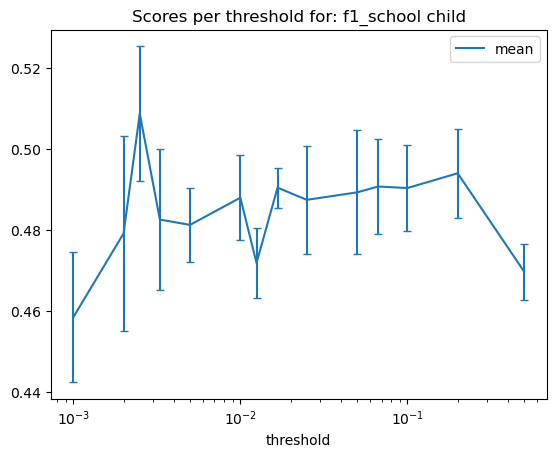

Slope for f1_school child: -0.017400663648785137
Standard deviation: 0.025543247501315938
p-value: 0.5086631656955566


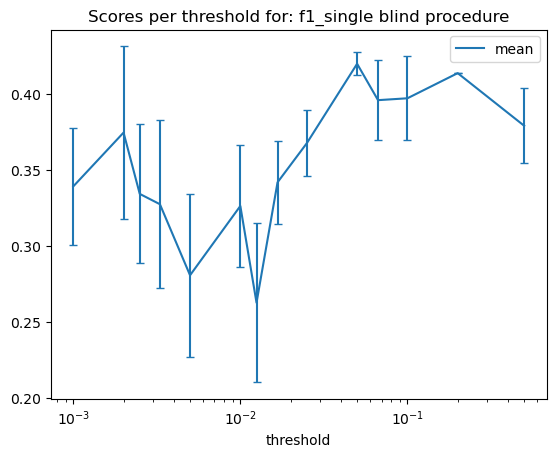

Slope for f1_single blind procedure: 0.13821889678959431
Standard deviation: 0.09211535117686369
p-value: 0.15933020213264895


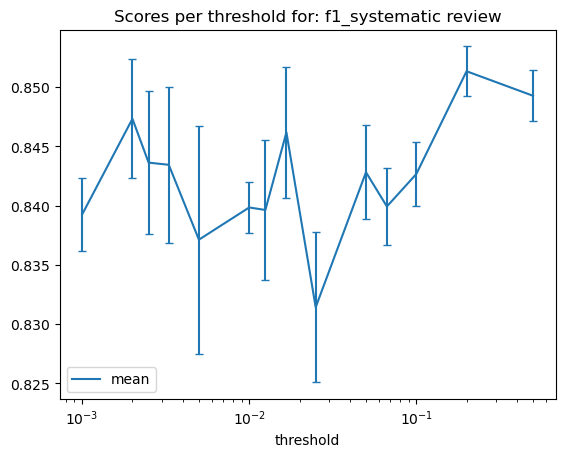

Slope for f1_systematic review: 0.02020502106510049
Standard deviation: 0.009361284421383153
p-value: 0.051863074317868185


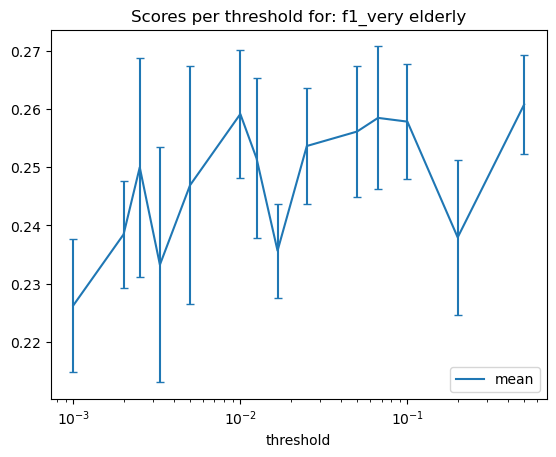

Slope for f1_very elderly: 0.029036278759355775
Standard deviation: 0.022489832283936903
p-value: 0.22099213270200113


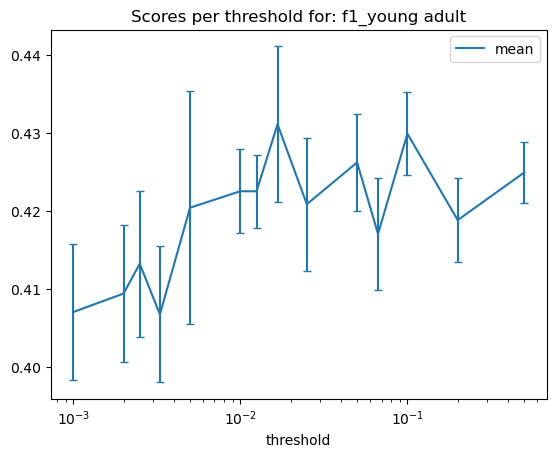

Slope for f1_young adult: 0.017507560300538585
Standard deviation: 0.016011391054681308
p-value: 0.2956632535712572
        index                label_threshold     score                      label  threshold
3         623                 f1_human-0.001  0.972937                   f1_human      0.001
17        637                 f1_human-0.001  0.973204                   f1_human      0.001
31        651                 f1_human-0.001  0.973178                   f1_human      0.001
45        665                 f1_human-0.001  0.973310                   f1_human      0.001
59        679                 f1_human-0.001  0.973300                   f1_human      0.001
...       ...                            ...       ...                        ...        ...
124431    734  f1_phase 4 clinical trial-0.5  0.000000  f1_phase 4 clinical trial      0.500
124445    748  f1_phase 4 clinical trial-0.5  0.000000  f1_phase 4 clinical trial      0.500
124459    762  f1_phase 4 clinical trial-0.5  0

In [39]:
visualize_individual_label_performance(model_results_df)
# visualise_f1_score(model_results_df)

In [37]:
model_results_df.loc[(model_results_df['gnn_type'] == 'GAT') & \
                     (model_results_df['num_conv_layers'] == 1) & \
                     (model_results_df['embedding_size'] == 256) & \
                     (model_results_df['graph_num_epochs'] > 500) & \
                     (model_results_df['heads'] == 4), :].dropna(subset=['f1_fetus'])

,date,id,gnn_type,graph_train_f1_score_macro,graph_train_precision_macro,graph_train_recall_macro,graph_train_f1_score_micro,graph_train_precision_micro,graph_train_recall_micro,graph_test_f1_score_macro,graph_test_precision_macro,graph_test_recall_macro,graph_test_f1_score_micro,graph_test_precision_micro,graph_test_recall_micro,lgbm_train_f1_score_macro,lgbm_train_precision_macro,lgbm_train_recall_macro,lgbm_train_f1_score_micro,lgbm_train_precision_micro,lgbm_train_recall_micro,lgbm_test_f1_score_macro,lgbm_test_precision_macro,lgbm_test_recall_macro,lgbm_test_f1_score_micro,lgbm_test_precision_micro,lgbm_test_recall_micro,num_samples,embedding_type,pretrain_epochs,graph_num_epochs,layers,heads,emb_size,hidden_channels,lgbm_params,graph_val_f1_score_macro,graph_val_precision_macro,graph_val_recall_macro,graph_val_f1_score_micro,graph_val_precision_micro,graph_val_recall_micro,lgbm_val_f1_score_macro,lgbm_val_precision_macro,lgbm_val_recall_macro,lgbm_val_f1_score_micro,lgbm_val_precision_micro,lgbm_val_recall_micro,pretrain_lr,pretrain_weight_decay,pretrain_optimizer,pretrain_loss,graph_optimizer,graph_lr,graph_weight_decay,graph_loss,graph_fl_gamma,graph_fl_alpha,edge_weight_threshold,dropout,scheduler,subsample_size,total_dataset_size,data_type_to_use,embedding_size,num_conv_layers,used_gnn,f1_m,f1_o,f1_d,f1_e,f1_l,f1__,f1_g,f1_.,f1_c,f1_s,f1_v,pr_m,pr_o,pr_d,pr_e,pr_l,pr__,pr_g,pr_.,pr_c,pr_s,pr_v,re_m,re_o,re_d,re_e,re_l,re__,re_g,re_.,re_c,re_s,re_v,f1_adolescent,f1_adult,f1_aged,f1_animal cell,f1_animal experiment,f1_animal model,f1_animal tissue,f1_case control study,f1_case report,f1_child,f1_clinical article,f1_clinical trial,f1_cohort analysis,f1_controlled clinical trial,f1_controlled study,f1_cross-sectional study,f1_crossover procedure,f1_diagnostic test accuracy study,f1_double blind procedure,f1_embryo,f1_female,f1_fetus,f1_human,f1_human cell,f1_human experiment,f1_human tissue,f1_infant,f1_longitudinal study,f1_major clinical study,f1_male,f1_meta analysis,f1_middle aged,f1_mouse,f1_multicenter study,f1_newborn,f1_nonhuman,f1_normal human,f1_observational study,f1_phase 1 clinical trial,f1_phase 2 clinical trial,f1_phase 3 clinical trial,f1_phase 4 clinical trial,f1_pilot study,f1_preschool child,f1_randomized controlled trial,f1_rat,f1_retrospective study,f1_school child,f1_single blind procedure,f1_systematic review,f1_very elderly,f1_young adult,pr_adolescent,pr_adult,pr_aged,pr_animal cell,pr_animal experiment,pr_animal model,pr_animal tissue,pr_case control study,pr_case report,pr_child,pr_clinical article,pr_clinical trial,pr_cohort analysis,pr_controlled clinical trial,pr_controlled study,pr_cross-sectional study,pr_crossover procedure,pr_diagnostic test accuracy study,pr_double blind procedure,pr_embryo,pr_female,pr_fetus,pr_human,pr_human cell,pr_human experiment,pr_human tissue,pr_infant,pr_longitudinal study,pr_major clinical study,pr_male,pr_meta analysis,pr_middle aged,pr_mouse,pr_multicenter study,pr_newborn,pr_nonhuman,pr_normal human,pr_observational study,pr_phase 1 clinical trial,pr_phase 2 clinical trial,pr_phase 3 clinical trial,pr_phase 4 clinical trial,pr_pilot study,pr_preschool child,pr_randomized controlled trial,pr_rat,pr_retrospective study,pr_school child,pr_single blind procedure,pr_systematic review,pr_very elderly,pr_young adult,re_adolescent,re_adult,re_aged,re_animal cell,re_animal experiment,re_animal model,re_animal tissue,re_case control study,re_case report,re_child,re_clinical article,re_clinical trial,re_cohort analysis,re_controlled clinical trial,re_controlled study,re_cross-sectional study,re_crossover procedure,re_diagnostic test accuracy study,re_double blind procedure,re_embryo,re_female,re_fetus,re_human,re_human cell,re_human experiment,re_human tissue,re_infant,re_longitudinal study,re_major clinical study,re_male,re_meta analysis,re_middle aged,re_mouse,re_multicenter study,re_newborn,re_nonhuman,re_normal human,re_observational study,re_phase 1 clinical tria